## Parâmetros do modelo para iterações

In [5]:
preco_qav_por_litro                 = 4.49
preco_dolar               = 5.99     # R$
# valor_hefa_soja           = 1.13 # US$/L
quanto_tarifa_combustivel = 0.30

dict_preco_saf_dolar_por_litro = {
    'hefa_soja': 1.13,
    'hefa_macauba': 0.57,
    'hefa_palma': 1.13,
    'hefa_UCO': 1.32,
    'atj_cana': 1.86,
    'atj_milho': 1.27    
} # US$/L
dict_preco_saf_real_litro = {k: v * preco_dolar for k, v in dict_preco_saf_dolar_por_litro.items()}# R$/L

dict_elasticidade_preco = {
    'historico': -1.47,
    'boom_economico': -1.29,
    'recessao': -1.59,
}

fator_emissao_qav = 89 #emissao querosene fóssil
dict_fator_emissao_safs = {
    'hefa_soja_sem_luc': 20.1,
    'hefa_soja_com_luc': 47.4,
    'hefa_macauba_sem_luc': 53.7,
    'hefa_macauba_com_luc': 71,
    'hefa_palma_sem_luc': 48.3,
    'hefa_palma_com_luc': 94.5,
    'hefa_UCO': 21.2,
    'atj_cana_sem_luc': 22.4,
    'atj_cana_com_luc': 45.6,
    'atj_milho_sem_luc': 39.5,
    'atj_milho_com_luc': 81
}

dict_rota_materia_prima = { # materia_prima: fator_emissao_materia_prima
    'hefa_soja':    ['hefa_soja_sem_luc', 'hefa_soja_com_luc'],
    'hefa_macauba': ['hefa_macauba_sem_luc', 'hefa_macauba_com_luc'],
    'hefa_palma':   ['hefa_palma_sem_luc', 'hefa_palma_com_luc'],
    'hefa_UCO':     ['hefa_UCO'],
    'atj_cana':     ['atj_cana_sem_luc', 'atj_cana_com_luc'],
    'atj_milho':    ['atj_milho_sem_luc', 'atj_milho_com_luc']
}

lista_proporcao_blend_safs = [0.05, 0.10, 0.15, 0.20, 0.25,
                              0.30, 0.35, 0.40, 0.45, 0.50]

dict_mandato_emissao_por_ano = {
    2030: 0.03,
    2040: 0.13,
    2050: 0.23,
}

TOLERANCIA_VARIACAO_DEMANDA         = 1e-8
TOLERANCIA_MUDANCA_VARIACAO_DEMANDA = 1e-8

In [6]:
nome_excel = 'Cenários_dissertação_PC.xlsm'
#nome_aba_preco_qav = 'Preço do QAV'

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [8]:
potencial_energetico = pd.read_excel('Cenários_dissertação_PC.xlsm', sheet_name='Potencial energético')
potencial_energetico.columns = range(potencial_energetico.shape[1])
# potencial_energetico.head(5)

# Transforma a primeira linha em cabeçalho e filtra colunas Ano e Potencial Combustível Necessário
for i in range(1, potencial_energetico.iloc[0, 1:].shape[0], 2):
    if i > potencial_energetico.iloc[0, 1:].shape[0]:
        break
    nome_coluna = potencial_energetico.iloc[0, i]
    potencial_energetico = potencial_energetico.drop(potencial_energetico.columns[[i, i+1]], axis=1)
    potencial_energetico.iloc[0, i] = nome_coluna
    potencial_energetico.head()

potencial_energetico.columns = potencial_energetico.iloc[0]
potencial_energetico = potencial_energetico.dropna( axis=1, how='all').drop([0, 1]).reset_index(drop=True)
todas_demandas_intensidade_energetica = potencial_energetico.columns[1:].to_list()
print(f'{todas_demandas_intensidade_energetica = }')

potencial_energetico.tail(2)

todas_demandas_intensidade_energetica = ['BAU-Base', 'BAU-Moderada', 'BAU-Acelerada', 'Suave-Base', 'Suave-Moderada', 'Suave-Acelerada', 'Intensa-Base', 'Intensa-Moderada', 'Intensa-Acelerada']


,Ano,BAU-Base,BAU-Moderada,BAU-Acelerada,Suave-Base,Suave-Moderada,Suave-Acelerada,Intensa-Base,Intensa-Moderada,Intensa-Acelerada
49,2049,355900329443.074951,338001143972.582275,307172133146.176636,313457685426.678162,297693054757.796326,270540535981.651764,441956760359.358459,419729565357.912048,381446122992.902588
50,2050,360041221842.48999,340559265044.504333,307858101048.461426,315498123545.477539,298426409419.789185,269770924290.317017,450988714163.252991,426585556656.051392,385623980571.108276


1. estimar a entrada da SAF, ver o diferencial de valor em relação ao QAV
2. transmitir esse aumento para tarifa
3. assumir a elasticidade preço da demanda do paper que compartilhou (por exemplo, assumir o valor do Brasil para o período sem recessão, para ser conservador)
4. estimar a queda da demanda
5. estimar a nova demanda de saf
fazer até que não gera alteração significativa na demanda por SAF.
Isso mostraria quanto, sem medidas de amortecimento do aumento de custo, a demanda poderia cair e consequentemente o mercado de QAV e SAF, claro.


In [9]:
# from IPython.display import clear_output

def iteracoes(nome_demanda_intensidade_energetica: str, 
              elasticidade_preco: np.float64, 
              nome_rota_materia_prima: str,
              nome_fator_materia_prima: str,
              proporcao_blend_saf: np.float64,
              ano: np.int32,
              mandato_emissao: np.float64,
              ano_referencia: np.int32 = 2019):
    df_iteracoes = pd.DataFrame()
    variacao_demanda_anterior = np.inf
    variacao_demanda = -np.inf
    demanda_energetica = potencial_energetico[potencial_energetico['Ano'] == ano][nome_demanda_intensidade_energetica].values[0]
    saf_demandado = 0
    numero_iteracao = 0
    proporcao_blend_qav                                = 1 - proporcao_blend_saf
    preco_saf_por_litro                                = dict_preco_saf_real_litro[nome_rota_materia_prima]
    impacto_percentual_no_preco                        = (preco_saf_por_litro * proporcao_blend_saf + preco_qav_por_litro * proporcao_blend_qav) / (preco_qav_por_litro * proporcao_blend_qav) - 1
    aumento_preco_litro                                = impacto_percentual_no_preco * quanto_tarifa_combustivel
    # while numero_iteracao < 3:
    while abs(variacao_demanda - variacao_demanda_anterior) > TOLERANCIA_MUDANCA_VARIACAO_DEMANDA:
    # while True:
        variacao_demanda_anterior = variacao_demanda
        df_iteracao = pd.DataFrame()
        # aumento_preco_litro                                = (preco_saf * 0.05) / (preco_qav * 0.95) - 1
        variacao_preco                                     = saf_demandado * aumento_preco_litro
        variacao_demanda                                   = variacao_preco * elasticidade_preco
        emissao_referencia                                 = potencial_energetico[potencial_energetico['Ano'] == ano_referencia][nome_demanda_intensidade_energetica].values[0] * fator_emissao_qav
        fator_emissao_dif                                  = fator_emissao_qav - dict_fator_emissao_safs[nome_fator_materia_prima]
        df_iteracao                                        = pd.DataFrame([elasticidade_preco], columns=['elasticidade_preco'])
        df_iteracao['proporcao_blend_saf']                 = proporcao_blend_saf
        df_iteracao['nome_materia_prima']                  = nome_rota_materia_prima
        df_iteracao['nome_fator_materia_prima']            = nome_fator_materia_prima
        df_iteracao['nome_demanda_intensidade_energetica'] = nome_demanda_intensidade_energetica
        df_iteracao['Ano']                                 = ano
        df_iteracao['mandato_emissao']                     = mandato_emissao
        df_iteracao['numero_iteracao']                     = numero_iteracao
        demanda_energetica                                 = (1 + variacao_demanda) * demanda_energetica
        df_iteracao['demanda_intensidade_energetica']      = demanda_energetica
        df_iteracao['emissao_tudo_qav']                    = df_iteracao['demanda_intensidade_energetica'] * fator_emissao_qav
        df_iteracao['reducao_emissao_referencia']          = df_iteracao['mandato_emissao'] * emissao_referencia
        df_iteracao['reducao_via_saf_ano_referencia']      = df_iteracao['emissao_tudo_qav'] - emissao_referencia
        df_iteracao['reducao_via_saf_ano_destino']         = df_iteracao['reducao_via_saf_ano_referencia'] + df_iteracao['reducao_emissao_referencia']
        df_iteracao['demanda_energetica_saf']              = df_iteracao['reducao_via_saf_ano_destino'] / fator_emissao_dif
        df_iteracao['saf_demandado']                       = df_iteracao['demanda_energetica_saf'] / df_iteracao['demanda_intensidade_energetica']
        df_iteracao['variacao_demanda']                    = variacao_demanda if numero_iteracao > 0 else np.NaN
        df_iteracao['variacao_preco']                      = variacao_preco
        df_iteracao['impacto_percentual_no_preco']                      = impacto_percentual_no_preco
        # df_iteracao['calcula_proximo']                     = df_iteracao['variacao_demanda'].apply(lambda x: True if abs(x) > TOLERANCIA_VARIACAO_DEMANDA or pd.isnull(x) else False)
        df_iteracoes = pd.concat([df_iteracoes, df_iteracao])
        if variacao_demanda and abs(variacao_demanda) < TOLERANCIA_VARIACAO_DEMANDA:
            break
        saf_demandado = df_iteracao[df_iteracao['numero_iteracao'] == numero_iteracao]['saf_demandado'].values[0]
        # demanda_energetica    = df_iteracao[df_iteracao['numero_iteracao'] == numero_iteracao]['demanda_intensidade_energetica'].values[0]
        # clear_output()
        # print(f'{nome_demanda_intensidade_energetica  = }')
        # print(f'{elasticidade_preco  = }')
        # print(f'{nome_rota_materia_prima  = }')
        # print(f'{nome_fator_materia_prima  = }')
        # print(f'{proporcao_blend_saf  = }')
        # print(f'{ano  = }')
        # print(f'{numero_iteracao  = }')
        # print(f'{saf_demandado    = }')
        # print(f'{variacao_demanda = }')
        numero_iteracao += 1
        # if numero_iteracao > 10:
        #     input()
    return df_iteracoes

# iteracao('BAU-Base', -1.59, 'hefa_soja', 'hefa_soja_sem_luc', 2030, 0.03)

In [10]:
ordem_campos = ['nome_demanda_intensidade_energetica', 
                'elasticidade_preco', 
                'proporcao_blend_saf',
                'nome_materia_prima', 
                'nome_fator_materia_prima', 
                'Ano', 
                'numero_iteracao']

def iteracoes_dissertacao(lista_nome_demanda_intensidade_energetica: list[str],
                          dict_rota_materia_prima: dict[str: list[str]],
                          lista_proporcao_blend_safs: list[np.float64],
                          lista_elasticidades: list[np.float64], 
                          dict_mandato_emissao_por_ano: dict[int: np.float64], 
                          ano_referencia: np.int64 = 2019):
    assert len(lista_nome_demanda_intensidade_energetica) > 0, 'A lista de nomes de demanda intensidade energética não pode ser vazia'
    assert len(dict_mandato_emissao_por_ano) > 0, 'O mandato de emissão por ano não pode ser vazio'
    
    df_dissertacao = pd.DataFrame()
    for nome_rota_materia_prima, lista_fator_materia_prima in dict_rota_materia_prima.items():
        for nome_fator_materia_prima in lista_fator_materia_prima:
            for elasticidade_iteracao in lista_elasticidades:
                for proporcao_blend_saf in lista_proporcao_blend_safs:
                    for nome_demanda_intensidade_energetica in lista_nome_demanda_intensidade_energetica:
                        for ano, mandato_emissao in dict_mandato_emissao_por_ano.items():
                            # print(f'{nome_rota_materia_prima = }')
                            # print(f'{nome_fator_materia_prima = }')
                            # print(f'{elasticidade_iteracao = }')
                            # print(f'{blend_saf = }')
                            # print(f'{nome_demanda_intensidade_energetica = }')
                            # print(f'{ano = }')
                            df_iteracoes = iteracoes(nome_demanda_intensidade_energetica=nome_demanda_intensidade_energetica,
                                                     nome_rota_materia_prima=nome_rota_materia_prima,
                                                     elasticidade_preco=elasticidade_iteracao,
                                                     nome_fator_materia_prima=nome_fator_materia_prima,
                                                     proporcao_blend_saf=proporcao_blend_saf,
                                                     ano=ano,
                                                     mandato_emissao=mandato_emissao,
                                                     ano_referencia=ano_referencia)
                            df_dissertacao = pd.concat([df_dissertacao, df_iteracoes]).reset_index(drop=True)
                    
    return df_dissertacao.sort_values(by=ordem_campos, axis=0).reset_index(drop=True)
    # return df_dissertacao

In [11]:
lista_nome_demanda_intensidade_energetica = todas_demandas_intensidade_energetica
# lista_nome_demanda_intensidade_energetica = ['BAU-Base']
df_dissertacao = iteracoes_dissertacao(lista_nome_demanda_intensidade_energetica=lista_nome_demanda_intensidade_energetica, 
                                       lista_proporcao_blend_safs=lista_proporcao_blend_safs,
                                       dict_rota_materia_prima=dict_rota_materia_prima,
                                       lista_elasticidades=dict_elasticidade_preco.values(), 
                                       dict_mandato_emissao_por_ano=dict_mandato_emissao_por_ano)
df_dissertacao

,elasticidade_preco,proporcao_blend_saf,nome_materia_prima,nome_fator_materia_prima,nome_demanda_intensidade_energetica,Ano,mandato_emissao,numero_iteracao,demanda_intensidade_energetica,emissao_tudo_qav,reducao_emissao_referencia,reducao_via_saf_ano_referencia,reducao_via_saf_ano_destino,demanda_energetica_saf,saf_demandado,variacao_demanda,variacao_preco,impacto_percentual_no_preco
0,-1.59,0.05,atj_cana,atj_cana_com_luc,BAU-Acelerada,2030,0.03,0,2.786133e+11,2.479658e+13,7.254451e+11,6.150821e+11,1.340527e+12,3.088772e+10,1.108623e-01,NaN,0.000000e+00,0.130599
1,-1.59,0.05,atj_cana,atj_cana_com_luc,BAU-Acelerada,2030,0.03,1,2.766891e+11,2.462533e+13,7.254451e+11,4.438307e+11,1.169276e+12,2.694184e+10,9.737223e-02,-6.906249e-03,4.343553e-03,0.130599
2,-1.59,0.05,atj_cana,atj_cana_com_luc,BAU-Acelerada,2030,0.03,2,2.750108e+11,2.447596e+13,7.254451e+11,2.944565e+11,1.019902e+12,2.350004e+10,8.545133e-02,-6.065873e-03,3.815014e-03,0.130599
3,-1.59,0.05,atj_cana,atj_cana_com_luc,BAU-Acelerada,2030,0.03,3,2.735468e+11,2.434567e+13,7.254451e+11,1.641648e+11,8.896099e+11,2.049792e+10,7.493388e-02,-5.323252e-03,3.347957e-03,0.130599
4,-1.59,0.05,atj_cana,atj_cana_com_luc,BAU-Acelerada,2030,0.03,4,2.722699e+11,2.423202e+13,7.254451e+11,5.051780e+10,7.759629e+11,1.787933e+10,6.566767e-02,-4.668060e-03,2.935887e-03,0.130599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461209,-1.29,0.50,hefa_soja,hefa_soja_sem_luc,Suave-Moderada,2050,0.23,10,2.092108e+11,1.861976e+13,5.561746e+12,-5.561739e+12,6.550051e+06,9.506606e+04,4.544032e-07,-1.075894e-06,8.340262e-07,1.507506
461210,-1.29,0.50,hefa_soja,hefa_soja_sem_luc,Suave-Moderada,2050,0.23,11,2.092108e+11,1.861976e+13,5.561746e+12,-5.561744e+12,1.613935e+06,2.342431e+04,1.119651e-07,-2.651009e-07,2.055046e-07,1.507506
461211,-1.29,0.50,hefa_soja,hefa_soja_sem_luc,Suave-Moderada,2050,0.23,12,2.092108e+11,1.861976e+13,5.561746e+12,-5.561745e+12,3.976742e+05,5.771759e+03,2.758825e-08,-6.532098e-08,5.063642e-08,1.507506
461212,-1.29,0.50,hefa_soja,hefa_soja_sem_luc,Suave-Moderada,2050,0.23,13,2.092108e+11,1.861976e+13,5.561746e+12,-5.561745e+12,9.798707e+04,1.422164e+03,6.797756e-09,-1.609512e-08,1.247683e-08,1.507506


In [12]:
df_exportacao = df_dissertacao.sort_values(by=ordem_campos, axis=0).reset_index(drop=True).copy()

nomes_exportacao = {'elasticidade_preco': 'Elasticidade Preço',
                 'nome_materia_prima': 'Matéria Prima',
                 'proporcao_blend_saf': 'Proporção Blend SAF',
                 'nome_fator_materia_prima': 'Fator Matéria Prima',
                 'nome_demanda_intensidade_energetica': 'Nome da Curva',
                 'Ano': 'Ano',
                 'mandato_emissao': 'Mandato Emissão',
                 'numero_iteracao': 'Número Iteração',
                 'demanda_intensidade_energetica': 'Demanda Intensidade Energética',
                 'emissao_tudo_qav': 'Emissão Tudo QAV',
                 'reducao_emissao_referencia': 'Redução Emissão Referência',
                 'reducao_via_saf_ano_referencia': 'Redução Via SAF Ano Referência',
                 'reducao_via_saf_ano_destino': 'Redução Via SAF Ano Destino',
                 'demanda_energetica_saf': 'Demanda Energética SAF',
                 'saf_demandado': 'SAF Demandado',
                 'variacao_demanda': 'Variação Demanda',
                 'variacao_preco': 'Variação Preço',
                 'impacto_percentual_no_preco': 'Impacto Percentual Preço'
                 }

df_exportacao.rename(columns=nomes_exportacao, inplace=True)
df_exportacao

,Elasticidade Preço,Proporção Blend SAF,Matéria Prima,Fator Matéria Prima,Nome da Curva,Ano,Mandato Emissão,Número Iteração,Demanda Intensidade Energética,Emissão Tudo QAV,Redução Emissão Referência,Redução Via SAF Ano Referência,Redução Via SAF Ano Destino,Demanda Energética SAF,SAF Demandado,Variação Demanda,Variação Preço,Impacto Percentual Preço
0,-1.59,0.05,atj_cana,atj_cana_com_luc,BAU-Acelerada,2030,0.03,0,2.786133e+11,2.479658e+13,7.254451e+11,6.150821e+11,1.340527e+12,3.088772e+10,1.108623e-01,NaN,0.000000e+00,0.130599
1,-1.59,0.05,atj_cana,atj_cana_com_luc,BAU-Acelerada,2030,0.03,1,2.766891e+11,2.462533e+13,7.254451e+11,4.438307e+11,1.169276e+12,2.694184e+10,9.737223e-02,-6.906249e-03,4.343553e-03,0.130599
2,-1.59,0.05,atj_cana,atj_cana_com_luc,BAU-Acelerada,2030,0.03,2,2.750108e+11,2.447596e+13,7.254451e+11,2.944565e+11,1.019902e+12,2.350004e+10,8.545133e-02,-6.065873e-03,3.815014e-03,0.130599
3,-1.59,0.05,atj_cana,atj_cana_com_luc,BAU-Acelerada,2030,0.03,3,2.735468e+11,2.434567e+13,7.254451e+11,1.641648e+11,8.896099e+11,2.049792e+10,7.493388e-02,-5.323252e-03,3.347957e-03,0.130599
4,-1.59,0.05,atj_cana,atj_cana_com_luc,BAU-Acelerada,2030,0.03,4,2.722699e+11,2.423202e+13,7.254451e+11,5.051780e+10,7.759629e+11,1.787933e+10,6.566767e-02,-4.668060e-03,2.935887e-03,0.130599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461209,-1.29,0.50,hefa_soja,hefa_soja_sem_luc,Suave-Moderada,2050,0.23,10,2.092108e+11,1.861976e+13,5.561746e+12,-5.561739e+12,6.550051e+06,9.506606e+04,4.544032e-07,-1.075894e-06,8.340262e-07,1.507506
461210,-1.29,0.50,hefa_soja,hefa_soja_sem_luc,Suave-Moderada,2050,0.23,11,2.092108e+11,1.861976e+13,5.561746e+12,-5.561744e+12,1.613935e+06,2.342431e+04,1.119651e-07,-2.651009e-07,2.055046e-07,1.507506
461211,-1.29,0.50,hefa_soja,hefa_soja_sem_luc,Suave-Moderada,2050,0.23,12,2.092108e+11,1.861976e+13,5.561746e+12,-5.561745e+12,3.976742e+05,5.771759e+03,2.758825e-08,-6.532098e-08,5.063642e-08,1.507506
461212,-1.29,0.50,hefa_soja,hefa_soja_sem_luc,Suave-Moderada,2050,0.23,13,2.092108e+11,1.861976e+13,5.561746e+12,-5.561745e+12,9.798707e+04,1.422164e+03,6.797756e-09,-1.609512e-08,1.247683e-08,1.507506


In [13]:
nome_arquivo_saida = 'iteracoes.xlsx'

# Ordene as colunas trocando a ordem das colunas na lista campos_para_exportacao
campos_para_exportacao = ['Elasticidade Preço',
                          'Proporção Blend SAF',
                          'Matéria Prima',
                          'Fator Matéria Prima',
                        #   'Nome da Curva',
                          'Ano',
                          'Mandato Emissão',
                          'Número Iteração',
                          'SAF Demandado',
                          'Variação Demanda',
                          'Variação Preço',
                          'Impacto Percentual Preço'
                        #   'Demanda Intensidade Energética',
                        #   'Emissão Tudo QAV',
                        #   'Redução Emissão Referência',
                        #   'Redução Via SAF Ano Referência',
                        #   'Redução Via SAF Ano Destino',
                        #   'Demanda Energética SAF',
                         ]

with pd.ExcelWriter(nome_arquivo_saida, engine='openpyxl') as writer:
    for nome_demanda_intensidade_energetica in lista_nome_demanda_intensidade_energetica:
        df_exportacao[df_exportacao['Nome da Curva'] == nome_demanda_intensidade_energetica][campos_para_exportacao].to_excel(writer, sheet_name=nome_demanda_intensidade_energetica, index=False)

In [14]:
df_plot = df_dissertacao[(df_dissertacao['Ano'] == 2050) &
          (df_dissertacao['nome_materia_prima'] == 'atj_milho') &
          (df_dissertacao['proporcao_blend_saf'] == 0.50) &
          (df_dissertacao['nome_fator_materia_prima'] == 'atj_milho_com_luc') &
          (df_dissertacao['nome_demanda_intensidade_energetica'] == 'BAU-Base') &
          (df_dissertacao['elasticidade_preco'] == -1.47) 
          ].copy()
df_plot

,elasticidade_preco,proporcao_blend_saf,nome_materia_prima,nome_fator_materia_prima,nome_demanda_intensidade_energetica,Ano,mandato_emissao,numero_iteracao,demanda_intensidade_energetica,emissao_tudo_qav,reducao_emissao_referencia,reducao_via_saf_ano_referencia,reducao_via_saf_ano_destino,demanda_energetica_saf,saf_demandado,variacao_demanda,variacao_preco,impacto_percentual_no_preco
83742,-1.47,0.5,atj_milho,atj_milho_com_luc,BAU-Base,2050,0.23,0,3.600412e+11,3.204367e+13,5.561746e+12,7.862166e+12,1.342391e+13,1.677989e+12,4.660547,NaN,0.000000,1.694276
83743,-1.47,0.5,atj_milho,atj_milho_com_luc,BAU-Base,2050,0.23,1,-8.937115e+11,-7.954033e+13,5.561746e+12,-1.037218e+14,-9.816008e+13,-1.227001e+13,13.729274,-3.482248,2.368876,1.694276
83744,-1.47,0.5,atj_milho,atj_milho_com_luc,BAU-Base,2050,0.23,2,8.274143e+12,7.363987e+14,5.561746e+12,7.122172e+14,7.177790e+14,8.972237e+13,10.843706,-10.258181,6.978354,1.694276
83745,-1.47,0.5,atj_milho,atj_milho_com_luc,BAU-Base,2050,0.23,3,-5.876424e+13,-5.230018e+15,5.561746e+12,-5.254199e+15,-5.248637e+15,-6.560797e+14,11.164607,-8.102154,5.511670,1.694276
83746,-1.47,0.5,atj_milho,atj_milho_com_luc,BAU-Base,2050,0.23,4,4.314426e+14,3.839839e+16,5.561746e+12,3.837421e+16,3.837977e+16,4.797471e+15,11.119605,-8.341924,5.674778,1.694276
83747,-1.47,0.5,atj_milho,atj_milho_com_luc,BAU-Base,2050,0.23,5,-3.153112e+15,-2.806270e+17,5.561746e+12,-2.806511e+17,-2.806456e+17,-3.508070e+16,11.125738,-8.308300,5.651905,1.694276
83748,-1.47,0.5,atj_milho,atj_milho_com_luc,BAU-Base,2050,0.23,6,2.305834e+16,2.052192e+18,5.561746e+12,2.052168e+18,2.052173e+18,2.565217e+17,11.124899,-8.312882,5.655022,1.694276
83749,-1.47,0.5,atj_milho,atj_milho_com_luc,BAU-Base,2050,0.23,7,-1.686084e+17,-1.500615e+19,5.561746e+12,-1.500618e+19,-1.500617e+19,-1.875771e+18,11.125014,-8.312255,5.654595,1.694276
83750,-1.47,0.5,atj_milho,atj_milho_com_luc,BAU-Base,2050,0.23,8,1.232922e+18,1.097301e+20,5.561746e+12,1.097301e+20,1.097301e+20,1.371626e+19,11.124998,-8.312341,5.654654,1.694276
83751,-1.47,0.5,atj_milho,atj_milho_com_luc,BAU-Base,2050,0.23,9,-9.015535e+18,-8.023826e+20,5.561746e+12,-8.023826e+20,-8.023826e+20,-1.002978e+20,11.125000,-8.312329,5.654646,1.694276


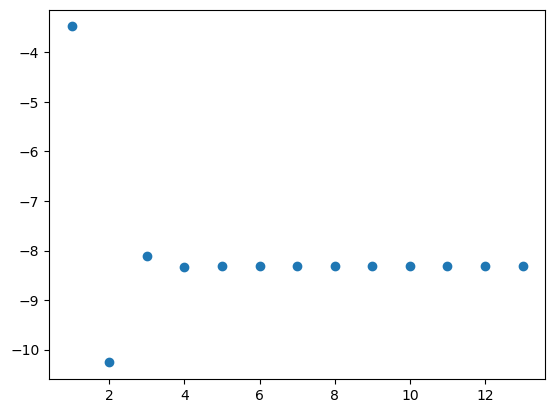

In [15]:
import matplotlib.pyplot as plt

plt.scatter(df_plot['numero_iteracao'], df_plot['variacao_demanda'])